In [1]:
import os
import glob
import cv2 
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from tqdm import tqdm
import gc

In [2]:
def readImage(location):
    image = nib.load(location)
    return np.array(image.get_fdata())[:,:,:,0]/np.array(image.get_fdata())[:,:,:,0].max()

In [3]:
def getSegments(subject):
    ret,thresh_low = cv2.threshold(subject,0.20,255,cv2.THRESH_BINARY)
    ret,thresh_med = cv2.threshold(subject,0.40,255,cv2.THRESH_BINARY)
    ret,thresh_high = cv2.threshold(subject,0.60,255,cv2.THRESH_BINARY)
    
    return np.array([
    cv2.bitwise_and(thresh_low[:,:,:],subject[:,:,:]),
    cv2.bitwise_and(thresh_med[:,:,:],subject[:,:,:]),
    cv2.bitwise_and(thresh_high[:,:,:],subject[:,:,:])])

In [4]:
#Alzhimers Dataset
ad = []
for x in tqdm(glob.glob('./Dataset/AD/*/*/*.nii')):
    ad.append(getSegments(readImage(x)))
    
ad = np.array(ad)

#Normal Dataset
cn = []
for x in tqdm(glob.glob('./Dataset/CN/*/*/*.nii')):
    cn.append(getSegments(readImage(x)))
    
cn = np.array(cn)


#MIC Dataset
mic = []
for x in tqdm(glob.glob('./Dataset/MIC/*/*/*.nii')):
    mic.append(getSegments(readImage(x)))
    
mic = np.array(mic)

gc.collect()

X = np.append(ad,cn,axis=0)
gc.collect()
X = np.append(X,mic,axis=0)
gc.collect()
Y = np.array([0]*ad.shape[0] + [1]*cn.shape[0] + [2]*mic.shape[0])
gc.collect()

100%|████████████████████████████████████████████████████████████████████████████████| 432/432 [00:49<00:00,  8.69it/s]


0

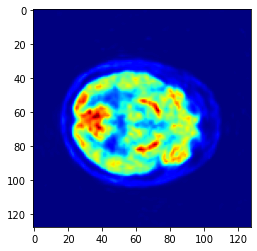

In [5]:
plt.imshow(readImage(glob.glob('./Dataset/AD/*/*/*.nii')[155])[:,:,30],cmap='jet')
plt.show()

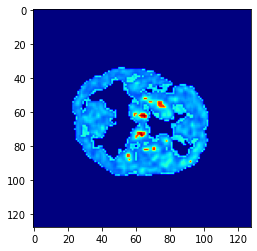

In [6]:
plt.imshow(X[100,0,:,:,32],cmap='jet')
plt.show()

In [7]:
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder()

In [8]:
Y= ohe.fit_transform(Y.reshape(-1,1))

In [9]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,Y,test_size=0.25)

In [10]:
y_train = y_train.toarray()
y_test = y_test.toarray()

## Making the Model

In [19]:
import keras
import tensorflow as tf
from keras.models import Model
from keras.layers import Conv3D,Dense,MaxPool3D,ReLU,Input,concatenate,Flatten,BatchNormalization, Dropout

In [27]:
#For low intensity segments
input_layer = Input(shape=(128,128,63,3),name='input_li')
model_li = Conv3D(filters=256, kernel_size=2, strides=2,padding='same', activation='relu', groups=3)(input_layer)
model_li = BatchNormalization(center=True, scale=True)(model_li)
model_li  = Dropout(0.5)(model_li)
model_li = Conv3D(filters=128, kernel_size=2, strides=2,padding='same', activation='relu', groups=3)(model_li)
model_li = BatchNormalization(center=True, scale=True)(model_li)
model_li  = Dropout(0.5)(model_li)

#Classification Network
classifier = Conv3D(filters=128, kernel_size=2, strides=2,padding='same', activation='relu')(model_li)
classifier = BatchNormalization(center=True, scale=True)(classifier)
classifier = Dropout(0.5)(classifier)
classifier = Conv3D(filters=64, kernel_size=2, strides=2,padding='same', activation='relu')(classifier)

flatten = Flatten()(classifier)

dense = Dense(128, activation='relu')(flatten)
output = Dense(3, activation='softmax')(dense)

ValueError: The number of filters must be evenly divisible by the number of groups. Received: groups=3, filters=256

In [25]:
model = Model([input_li,input_mi,input_hi],output)

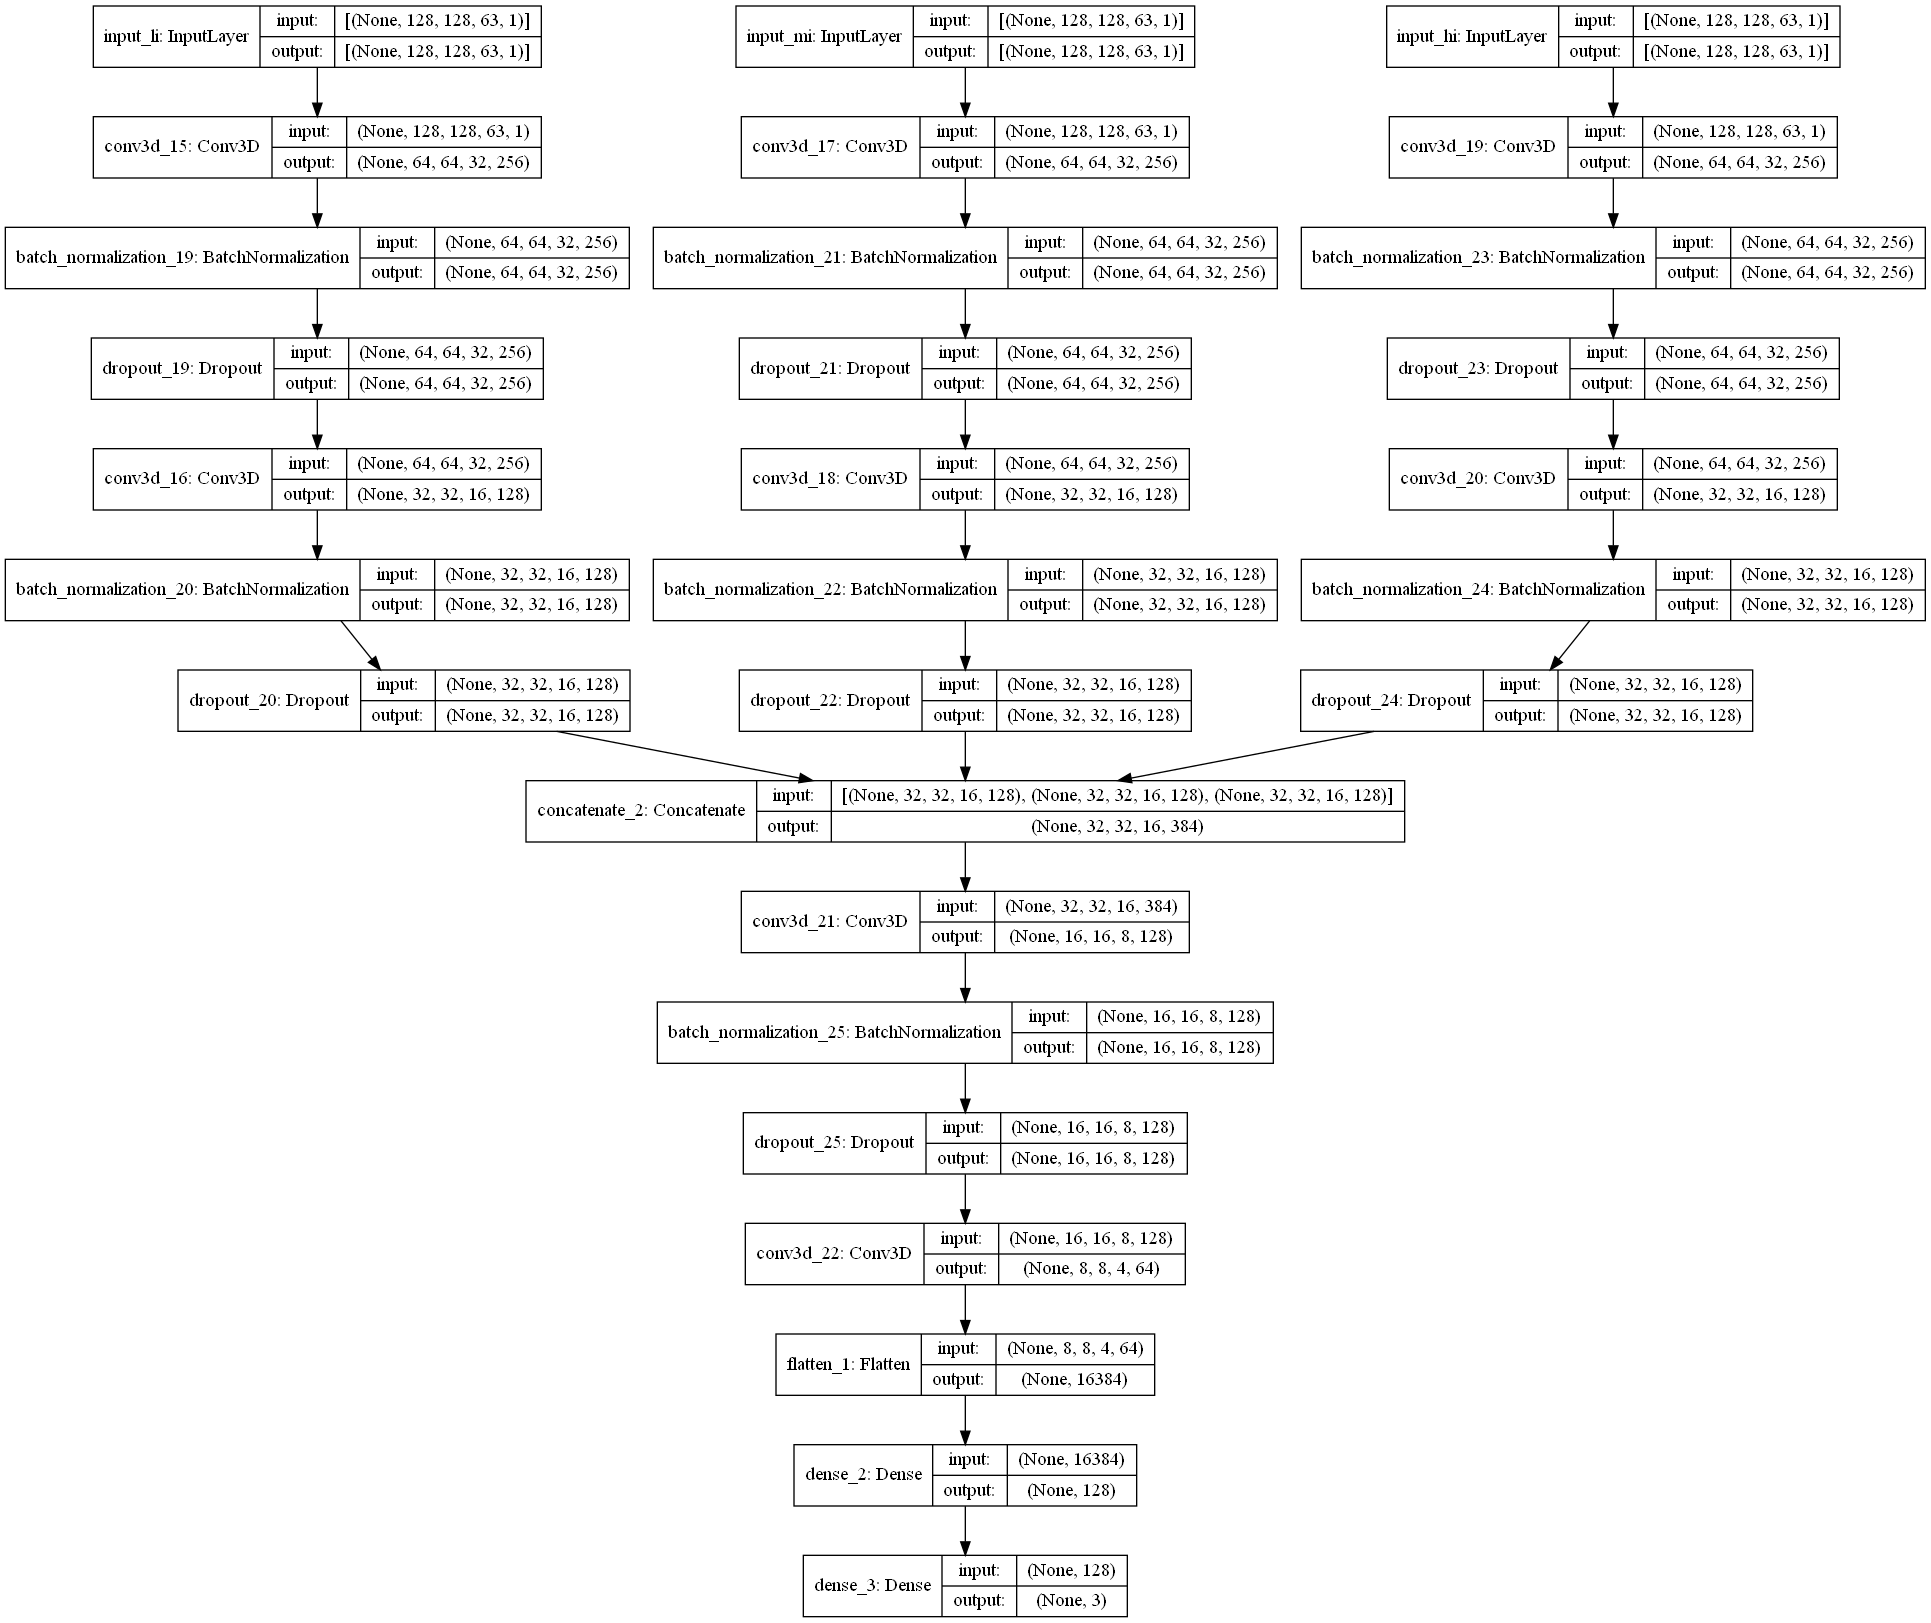

In [26]:
from tensorflow.keras.utils import plot_model
plot_model(model,show_shapes=True,show_layer_names=True,rankdir='TB',expand_nested=True)

In [15]:
model.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy'])

training_x = {'input_li':X_li_train,'input_mi':X_mi_train,'input_hi':X_hi_train}
testing_x = {'input_li':X_li_test,'input_mi':X_mi_test,'input_hi':X_hi_test}

In [16]:
X_li_train = X_train[:,0,:,:]
X_mi_train = X_train[:,1,:,:]
X_hi_train = X_train[:,2,:,:]

X_li_test = X_test[:,0,:,:]
X_mi_test = X_test[:,1,:,:]
X_hi_test = X_test[:,2,:,:]


#training_x = {'input_li':X_li_train,'input_mi':X_mi_train,'input_hi':X_hi_train}


In [17]:
train_set = tf.data.Dataset.from_tensor_slices(({'input_li':X_li_train,'input_mi':X_mi_train,'input_hi':X_hi_train}, y_train))
train_set = train_set.batch(2, drop_remainder=True)

test_set = tf.data.Dataset.from_tensor_slices(({'input_li':X_li_test,'input_mi':X_mi_test,'input_hi':X_hi_test}, y_test))
test_set = test_set.batch(2, drop_remainder=True)

MemoryError: Unable to allocate 5.78 GiB for an array with shape (751, 128, 128, 63) and data type float64

In [ ]:
model.fit(x=training_x,
          y=training_y,
          batch_size=5,
          epochs=1)